In [1]:
import sys
!{sys.executable} -m pip install tensorflow==2.3.1 gym keras-rl2 gym[atari]

You should consider upgrading via the 'c:\users\enoch\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


In [2]:
!{sys.executable} -m pip install torch

You should consider upgrading via the 'c:\users\enoch\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


In [1]:
# Load toolkit
import logging
import gym
import math
import random
import torch
import torch.nn as nn
import torch.optim
import torch.autograd
import numpy as np


import matplotlib.pyplot as plt
%matplotlib inline

from collections import deque
from env_wrapper import make_atari, wrap_deepmind, wrap_pytorch

USE_CUDA = torch.cuda.is_available() # if we have a gpu to make the compute faster

In [2]:
# Load game environment
env = gym.make('PongNoFrameskip-v4')
# Reset environment
observation = env.reset()
# Pixel shape
observation.shape

(210, 160, 3)

In [3]:
class Pong(torch.nn.Module):

    def __init__(self, action_num):
        super(Pong, self).__init__()
        # Three convolutional layers
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        # Two fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, action_num)
        )

    def forward(self, x):
        # evaluate the network and return the action values 
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def feature_size(self):
        # Return the size of last convolutional layer
        with torch.no_grad():
            feature_num = self.conv(torch.zeros(1, 1, 84, 84)).view(1, -1).size(1)
        return feature_num

    def action(self, state):
        # Choose action based on max action values
        state = to_tensor(state)
        if USE_CUDA:
            state = state.cuda()
        q_values = self.forward(state)
        return q_values.max(1)[1].data[0]

In [4]:
Pong(6)  # show the structure of the network

Pong(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=6, bias=True)
  )
)

In [4]:
def train():
    # Train begin
    # Sample batch data
    state, action, reward, next_state, done = zip(*random.sample(replay_buffer, batch_size))
    state = np.concatenate(state)
    next_state = np.concatenate(next_state)
    
    # Calculate loss
    # Input the data as tensors
    state = torch.Tensor(state)
    next_state = torch.Tensor(next_state)
    action = torch.LongTensor(action)
    reward = torch.Tensor(reward)
    done = torch.Tensor(done)
    # Use CUDA
    if USE_CUDA:
        state = state.cuda()
        next_state = next_state.cuda()
        action = action.cuda()
        reward = reward.cuda()
        done = done.cuda()
    # Calculate Q values based on the model
    q_values = model(state)
    next_q_values = model(next_state)

    q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value = next_q_values.max(1)[0]
    # Set expected_q_value
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    # Set loss
    loss = (q_value - expected_q_value).pow(2).mean()

    # Clear grad
    optimizer.zero_grad()
    # Backward
    loss.backward()
    # Grad step
    optimizer.step()
    # Train end

In [6]:
logger = logging.getLogger()
# game environment id
env_id = 'PongNoFrameskip-v4'
# env_id = 'Pong-v0'

round = 0
save_every_n_round = 100

render = False

one_round_max_frame = 10000
# Adam optimizer learning rate
learning_rate = 0.00001
# exploration rates at beginning and at the end
epsilon_begin = 1
epsilon_end = 0.02

# Set experience replay buffer size
replay_buffer_size = 100000
replay_initial = 10000
# Set batch size
batch_size = 32
# Set discount
gamma = 0.99

# Output the model
model_file = "batch_"+str(batch_size)+"_pong.model"
file_handler = logging.FileHandler(str(batch_size)+".log")
file_handler.setLevel(logging.INFO)
logger.setLevel(logging.INFO)
logger.addHandler(file_handler)

def to_tensor(I):
    return torch.Tensor(I).unsqueeze(0)

In [7]:
# Accepts a tuple (s,a,r,s') and keeps a list, returns a random batch of tuples as needed
replay_buffer = deque(maxlen=replay_buffer_size)
# Set environment that skip over the 4 observations over all the time steps
env = make_atari(env_id)
# Configure environment for DeepMind-style Atari
env = wrap_deepmind(env)
# Set the environment that can be used in pytorch
env = wrap_pytorch(env)
model = Pong(env.action_space.n)
if USE_CUDA:
    model = model.cuda()
# Train step
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# Set the initial exploration rate
epsilon = epsilon_begin
epsilon_decay = 30000
# Decay exploration from 1 to 0.02
import math
epsilon_by_frame = lambda frame_idx: epsilon_end + (epsilon_begin - epsilon_end) * math.exp(-1. * frame_idx / epsilon_decay)
frame_seq = 0
round_reward = 0
# while True:
for _ in range(20):
    break
    # reset environment
    state = env.reset()
    # state = pre_process(state)
    # state = np.concatenate([state, state])

    round_over = False
    # Runing until the game round over
    while not round_over:
        # Set exploration rate
        epsilon = epsilon_by_frame(frame_seq)
        # behave according to an epsilon greedy policy
        action = env.action_space.sample()
        if random.random() > epsilon:
            action = model.action(state)
        # agent takes the action, and the environment responds
        next_state, reward, done, _ = env.step(action)
        round_over = done
        # next_state = pre_process(next_state)
        # next_state = np.concatenate([state[80:], next_state])

        # push to replay buffer
        s = np.expand_dims(state, 0)
        ns = np.expand_dims(next_state, 0)
        replay_buffer.append((s, action, reward, ns, done))
        # update the state
        state = next_state
        frame_seq += 1
        # print(frame_seq)
        # Gather the rewards
        round_reward += reward
        # Start training when there are enough memory exists
        if len(replay_buffer) > replay_initial:
            train()

        if frame_seq % 10000 == 0:
            # print("saving model", frame_seq)
            logger.info("current round: "+str(round)+"saving model")
            # from datetime import datetime
            # start = datetime.now()
            torch.save(model, model_file)
            # print(datetime.now() - start)
    # Caculate round number
    round += 1
    # print("round over", round_reward)
    logger.info("round reward: "+str(round_reward))
    round_reward = 0

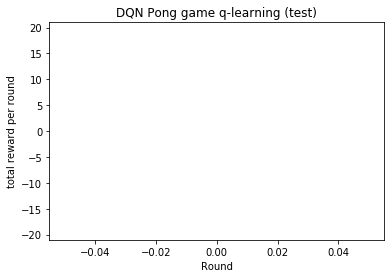

we win at rate  1.0


In [8]:
# Load the model
pong = torch.load("nGbatch_32_pong.model",map_location=torch.device('cpu'))
# Set test rounds
test_rounds = 1
win_num = 0
score = []
current = 0
for round in range(test_rounds):
    # reset the environment
    state = env.reset()
    current = 0
    round_over = False
    # Running until the round over
    while not round_over:
        env.render()
        # Running greedy 
        action = pong.action(state)
        # agent takes the action, and the environment responds
        next_state, reward, round_over, _ = env.step(action)
        # Caculate round reward
        current += reward
        # Update state
        state = next_state
    # Calculate number of victory
    if reward > 0:
        win_num+=1
    score.append(current)
# Plot the result
plt.plot(score)
plt.xlabel('Round')
plt.ylabel('total reward per round')
plt.title('DQN Pong game q-learning (test)')
plt.ylim((-21,21))
plt.show()
# Print the wining rate
print("we win at rate ", win_num/test_rounds)

In [8]:
# Read the log trail
def read_log(filename):
    results = []
    with open(filename) as f:
        for line in f:
            if line.startswith("round reward"):
                reward = line.replace("\n", "").replace("\r", "").replace("round reward: ", "")
                results.append(float(reward))
    return results

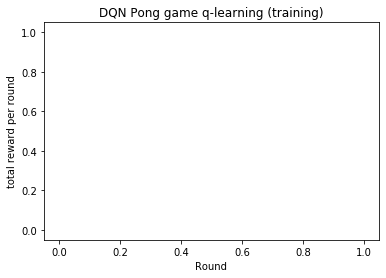

In [9]:
# Plot the result
plt.plot(read_log("32.log"))  # reward of the train process
plt.xlabel('Round')
plt.ylabel('total reward per round')
plt.title('DQN Pong game q-learning (training)')
plt.show()